# Loan Default Analysis – Results
This notebook presents the key findings and visualizations from our analysis of credit default risk.  
The goal is to identify the main drivers of default and highlight high-risk borrowers using a simple, interpretable model.

I analyzed a dataset of 32,566 loan applications, focusing on borrower characteristics and loan features.  
The target variable is whether a borrower defaulted ('loan_status'), and we modeled the risk using logistic regression.  

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

In [2]:
# load dataset
df = pd.read_csv('../data/processed/credit_risk_cleaned.csv')

1. Default rate by loan purpose
Shows which loan purposes are most risky for default.

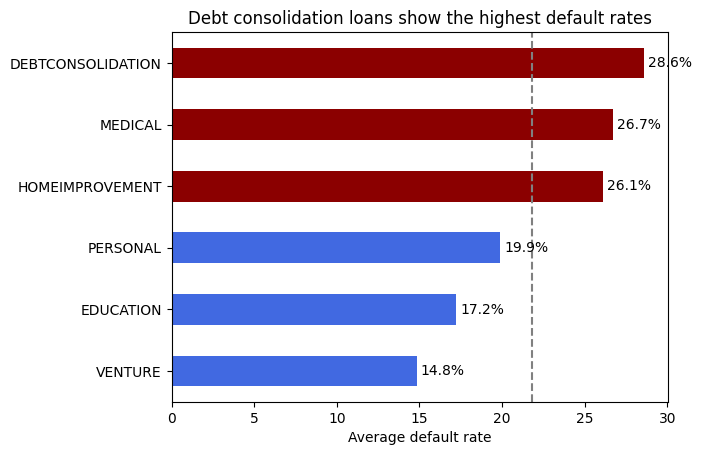

In [50]:
#plt.style.use('seaborn-v0_8-deep')
# Default rate by loan purpose
fig, ax = plt.subplots()

# Color bars: red if above overall mean risk
colors = ['royalblue','royalblue', 'royalblue', 'darkred','darkred', 'darkred']
mean_risk = df['loan_status'].mean() * 100

loan_intent = (df.groupby('loan_intent')['loan_status'].mean() * 100).sort_values()
loan_intent.plot(kind='barh',
                 title='Debt consolidation loans show the highest default rates',
                 xlabel='Average default rate',
                 ylabel='',
                 color= colors,ax=ax)

# put percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

ax.axvline(mean_risk, color='gray', linestyle='--', label='Average default rate')

plt.show()


Borrowers taking loans for certain purposes show higher default rates. Bars above the gray line indicate above-average risk. 

2. Default rate by home ownership
Compares risk levels for renters, owners, etc.

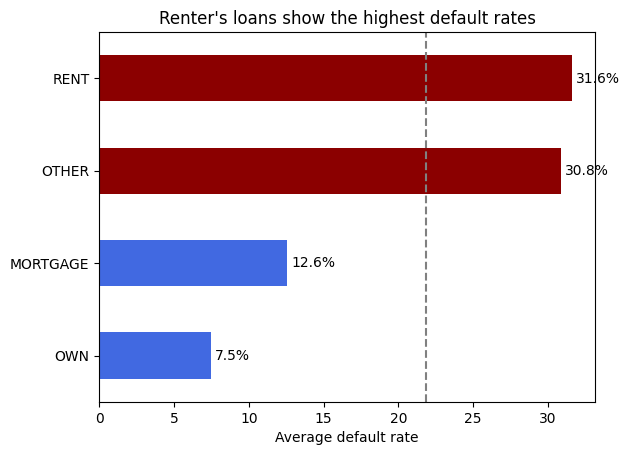

In [17]:
# Default rate by home ownership
fig, ax = plt.subplots()

# Color bars: red if above overall mean risk
colors = ['royalblue','royalblue', 'darkred', 'darkred']

home_ownership = (df.groupby('person_home_ownership')['loan_status'].mean() * 100).sort_values()
home_ownership.plot(kind='barh',
                 title="Renter's loans show the highest default rates",
                 xlabel='Average default rate',
                 ylabel='',
                 color= colors,ax=ax)

# put percentage labels on the bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=3)

ax.axvline(mean_risk, color='gray', linestyle='--', label='Average default rate')

plt.show()

Renters tend to have a slightly higher default rate than homeowners,suggesting that financial stability (proxied by home ownership) may reduce credit risk.

3. Actual vs historical default
Checks if borrowers with past defaults tend to default again.

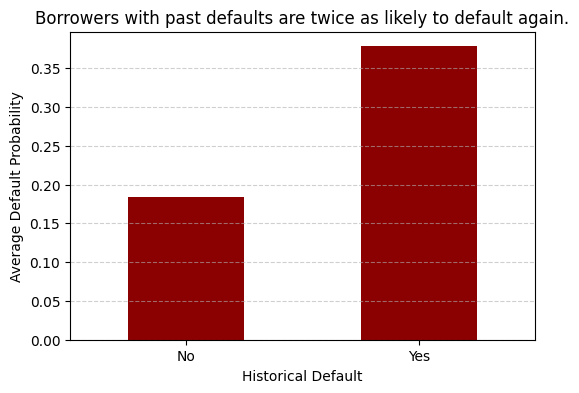

In [49]:
# Actual vs historical default
fig, ax = plt.subplots(figsize=(6,4))

# mean default rate per group
high_risk_counts = df.groupby('default')['loan_status'].mean()  
high_risk_counts.plot(kind='bar', color='darkred', ax=ax)

ax.set_ylabel('Average Default Probability')
ax.set_title('Borrowers with past defaults are twice as likely to default again.')
ax.xaxis.set_tick_params(rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.6)
ax.set_xticklabels(['No', 'Yes'])
ax.set_xlabel('Historical Default')

plt.show()

Borrowers who previously defaulted have a much higher probability of defaulting again.

4. Prediction with logistic regression
Shows how default probability increases with the loan-to-income ratio.

In [23]:
# Fit logistic regression
model = smf.logit('loan_status ~ loan_percent_income', data=df)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.454510
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            loan_status   No. Observations:                32566
Model:                          Logit   Df Residuals:                    32564
Method:                           MLE   Df Model:                            1
Date:                Tue, 14 Oct 2025   Pseudo R-squ.:                  0.1337
Time:                        14:21:09   Log-Likelihood:                -14802.
converged:                       True   LL-Null:                       -17086.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              -2.9186      0.032    -90.798      0.000      -2.982      -2.856
loan_percent_income     8.5139      0.137     62.001      0.000       8.245       8.783
=======================================================================================
"""

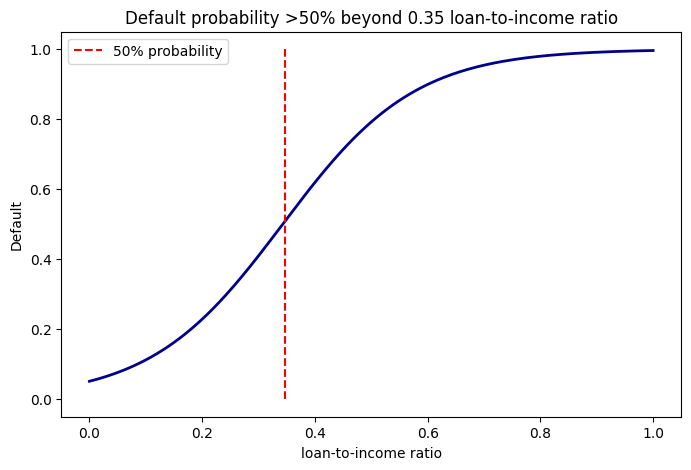

In [40]:
# Probability curve with 50% threshold
X = np.linspace(0, 1, 200)
X_df = pd.DataFrame(X)
X_df.columns = ['loan_percent_income']
p_y = results.predict(X_df)

fig, ax = plt.subplots(figsize=(8,5))

# plot predicted probability
ax.plot(X_df['loan_percent_income'], p_y, color='darkblue', linewidth=2)

# 50% threshold
x_50 = X_df['loan_percent_income'][p_y >= 0.5].iloc[0]
ax.vlines(x=x_50, ymin=0, ymax=1, colors='red', linestyles='--', label='50% probability')

# labels
ax.set_xlabel('loan-to-income ratio')
ax.set_ylabel('Default')
ax.set_title('Default probability >50% beyond 0.35 loan-to-income ratio')
ax.legend()

plt.show()

 50% probability threshold: borrowers with loan-to-income ratio above ~0.35 are high-risk.  

5. Distribution of predicted probabilities
Shows how many borrowers the model considers low, medium, or high risk.

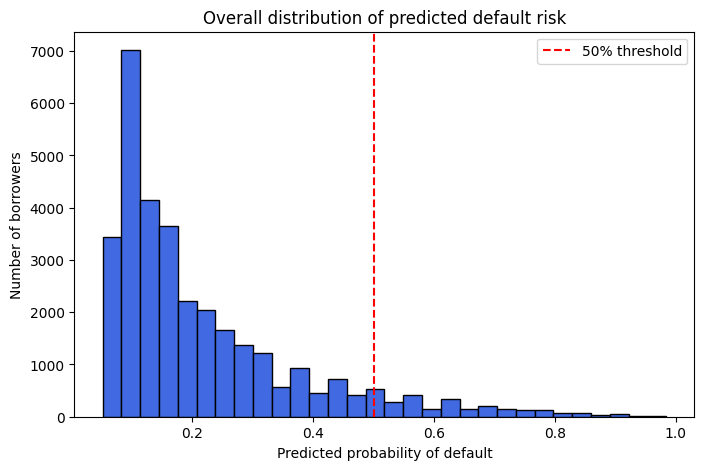

In [29]:
# Predict probabilities for each borrower
df['predicted'] = results.predict(df)

# Plot distribution
plt.figure(figsize=(8,5))
plt.hist(df['predicted'], bins=30, color='royalblue', edgecolor='black')
plt.axvline(0.5, color='red', linestyle='--', label='50% threshold')

plt.title("Overall distribution of predicted default risk")
plt.xlabel("Predicted probability of default")
plt.ylabel("Number of borrowers")
plt.legend()
plt.show()

Most borrowers have a low predicted probability of default. A smaller group lies to the right of the red dashed line — these are considered high-risk customers.
This visualization helps identify how many clients the model classifies as risky and gives an overview of the overall risk profile.
The portfolio is generally healthy, but a small high-risk segment deserves closer attention.